In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import os
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.models.segmentation as models

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
sys.path.append("..")

from src.models.unet import UNet
from src.lightning_models.unet_lightning_model import UNetLightningModel
from src.datasets.sky_finder_cover_dataset import SkyFinderCoverModule
from src.config import (
    UNET_CHECKPOINT_PATH,
    DEVICE,
    SEED,
)

In [50]:
# Get model
model = UNet(pretrained=True).to(DEVICE)
lightning_model = UNetLightningModel.load_from_checkpoint(
    UNET_CHECKPOINT_PATH,
    model=model,
    learning_rate=0,
    weight_decay=0,
    name="unet",
    dataset="sky_finder_cover",
)
model = lightning_model.model.to(DEVICE)
model.eval()
None

In [51]:
module = SkyFinderCoverModule(
    batch_size=1,
    n_workers=1,
    seed=SEED
)
module.setup(stage="fit")
module.setup(stage="test")
train_dataloader = module.train_dataloader()
val_dataloader = module.val_dataloader()

🌱 Setting the seed to 0 for generating dataloaders.
🌱 Setting the seed to 0 for generating dataloaders.


In [52]:
def unnormalize(
        image,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ):
    image = image.copy()
    image = image * std + mean
    image = image.clip(0, 1)
    return image

In [55]:
it = iter(val_dataloader)

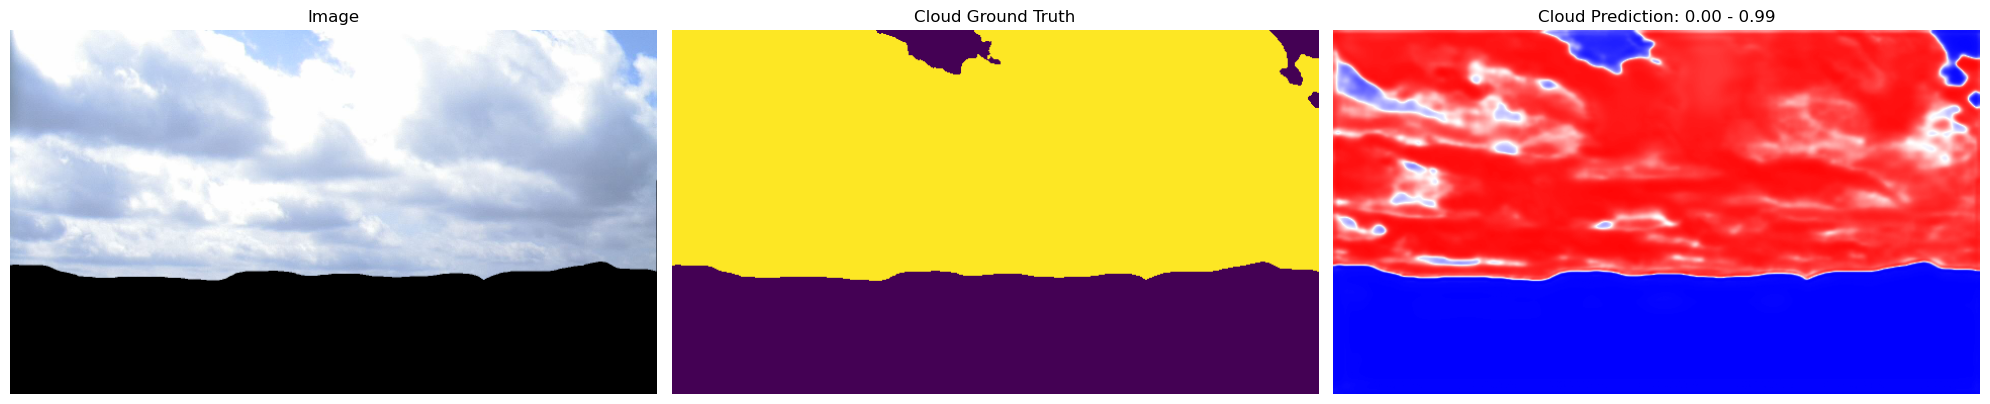

In [77]:
batch = next(it)
image = batch[0][0]
cloud_ground_truth = batch[1][0]
bloom_ground_truth = batch[2][0]

with torch.no_grad():
    prediction = model(image.unsqueeze(0).to(DEVICE))
    cloud_prediction = prediction[0, 0, :, :].cpu()
    cloud_prediction = torch.sigmoid(cloud_prediction)
    bloom_prediction = prediction[0, 1, :, :].cpu()
    bloom_prediction = torch.sigmoid(bloom_prediction)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(unnormalize(image.numpy().transpose(1, 2, 0)))
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Cloud Ground Truth")
plt.imshow(cloud_ground_truth.numpy().transpose(1, 2, 0), vmin=0, vmax=1)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title(f"Cloud Prediction: {torch.min(cloud_prediction):.2f} - {torch.max(cloud_prediction):.2f}")
plt.imshow(cloud_prediction.numpy(), vmin=0, vmax=1, cmap="bwr")
plt.axis("off")
plt.tight_layout()
plt.show()